# 강외생성하 선형회귀
- 작성자: 고려대학교 경제학과 한치록 교수

설명변수($X_{it}$)와 고유오차항($\varepsilon_{it}$) 강외생성(strict exogeneity)이 성립하는 경우를 살펴본다. 4개의 회귀가 많이 사용된다.

1. Pooled OLS (POLS)
2. Between-group regression (BE)
3. Fixed-effects regression (FE)
4. Random-effects feasible GLS regression (RE)

`bok_da` 라이브러리 `paneldata` 모듈에 위 4가지 회귀를 구현해 두었다. 그 외에도 GEE, MLE 등이 있지만, 이들을 전부 구현하기보다는 [Python용 Stata에 인터페이스](../9%20Stata)를 사용하는 것을 권고한다.

선형 패널모형 회귀는 [linearmodels](https://bashtage.github.io/linearmodels/) 패키지에 상당 부분 구현되어 있지만 결과의 신뢰성을 고려하여 새로운 모듈을 만들기로 결정하였다.

## Pooled OLS (POLS)

POLS는 데이터를 전부 활용하는 OLS일 뿐이므로 2절 설명을 따르면 된다. '견고한 표준오차'는 클러스터 표준오차를 의미한다. 'Formula' 인터페이스를 구현해 두었다. 아래에서는 공선성을 해결하는지 시험하기 위해 특이하게 모형을 만들었다.

#### **(주의) 본 매뉴얼에서 Stata 기능은 라이선스 이슈로 아직까지는 BIDAS 환경에서 사용할 수 없다. 매뉴얼에서 stata 관련 코드는 주석처리하였다. 로컬환경(내부망, 인터넷망)에서 활용하는 경우 주석해제 하여 사용할 수 있다.**

In [1]:
import bok_da
from bok_da.panel.linear_model import PanelData, xtreg

In [3]:
xtdf = PanelData('../data/nlswork.dta', 'idcode', 'year')

fm0 = 'ln_wage~grade+age+I(age**2)+ttl_exp+tenure+C(race)+not_smsa+south+I(south+age)'
fm1 = fm0 + '+C(year)'
ans = xtreg(fm1, xtdf, method='pols', vce='r')
print(ans.summary(slim=True))

note: I(south + age) omitted because of collinearity.
                        Pooled OLS Regression Results                         
Dep. Variable:                ln_wage   R-squared:                      0.3754
Model:                            OLS   Adj. R-squared:                 0.3749
No. Observations:               28091   F-statistic:                     241.8
Covariance Type:              cluster   Prob (F-statistic):             0.0000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -0.21586    0.07836      -2.75      0.006    -0.36945    -0.06227
C(race)[T.Black]   -0.06612    0.00992      -6.66      0.000    -0.08557    -0.04667
C(race)[T.Other]    0.03155    0.04806       0.66      0.511    -0.06264     0.12574
C(year)[T.69]       0.04751    0.01086       4.37      0.000     0.02623     0.06880
C(year)[T.70]      -0.01641    0.01093   

공선성은 해결된다.

### 표준오차

통상적인 표준오차(디폴트로 계산)는 `xtreg` 메쏘드에서 `vce='o'` 인자를 사용하고, 클러스터 표준오차는 `vce='r'` 인자를 사용하면 된다.

## Between-group regression (BE)

BE 회귀는 $\bar{y}_i$를 $\bar{x}_i$에 대하여 OLS하는 것이다. `xtreg`에서 `method='be'`라고 하면 된다. 표준오차는 `vce='o'`이면 통상적인 표준오차, `vce='r'`이면, "HC1"과 동일, 나머지 옵션은 `cov_type=` 옵션으로 그대로 사용된다. Stata의 `xtreg,be`는 robust standard error 옵션을 제공하지 않는다.

연도 더미가 있으면 공선성이 발생할 수 있고 파이썬의 Statsmodels는 공선성을 제대로(변수 누락으로써) 처리하지 않는다. `xt` 모듈의 `PanelData.xtreg` 메쏘드에 공선성 체크와 자동 변수 누락을 구현해 두었다. 변수가 자동으로 누락될 때 절편이 누락되는 경우도 있으므로 상당한 주의를 기울여야 할 것이다. 이런 점이 복잡하면 아래에 제시하는 Stata 인터페이스를 사용하면 될 것이다.

In [4]:
xtdata = PanelData('../data/nlswork.dta', 'idcode')

fm0 = 'ln_wage~grade+age+I(age**2)+ttl_exp+tenure+C(race)+not_smsa+south'
fm1 = fm0 + '+C(year)'

be = xtreg(fm1, xtdata, method='be')
be.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Between-effects Regression Results                      
==============================================================================
Dep. Variable:                ln_wage   R-squared:                      0.4951
Model:                            OLS   Adj. R-squared:                 0.4926
No. Observations:                4697   F-statistic:                     199.3
Covariance Type:            nonrobust   Prob (F-statistic):             0.0000
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -0.04288    0.13709      -0.31      0.754    -0.31164     0.22587
C(race)[T.Black]   -0.04945    0.01052      -4.70      0.000    -0.07007    -0.02882
C(race)[T.Other]    0.08504    0.04054       2.10      0.036     0.00557     0.16452
C(year)[T.69]       0.01376    0.04924       0.28      0.780    -0.08277     0.11029
C(year)[T.70]      -0.05244    0.04647      -1.13      0.259    -0.14354     0.03865
C(year)[T.71]      -0.13071    0.04166      -3.14      0.002    -0.21239    -0.04903
C(year)[T.72]      -0.07814    0.04763      -1.64      0.101    -0.17150     0.01523
C(year)[T.73]      -0.10835    0.04613      -2.35      0.019    -0.19879    -0.01790
C(year)[T.75]      -0.26183    0.04508      -5.81      0.000    -0.35020    -0.17346
C(year)[T.77]      -0.11490    0.04737      -2.43      0.015    -0.20778    -0.02203
C(year)[T.78]      -0.05845    0.05327      -1.10      0.273    -0.16289     0.04598
C(year)[T.80]      -0.23219    0.05705      -4.07      0.000    -0.34403    -0.12035
C(year)[T.82]      -0.30580    0.05450      -5.61      0.000    -0.41264    -0.19895
C(year)[T.83]      -0.21445    0.05266      -4.07      0.000    -0.31769    -0.11122
C(year)[T.85]      -0.22771    0.04875      -4.67      0.000    -0.32328    -0.13213
C(year)[T.87]      -0.22464    0.05066      -4.43      0.000    -0.32396    -0.12533
C(year)[T.88]      -0.28064    0.04457      -6.30      0.000    -0.36802    -0.19326
grade               0.06157    0.00199      31.00      0.000     0.05767     0.06546
age                 0.06113    0.00973       6.28      0.000     0.04205     0.08021
I(age ** 2)        -0.00096    0.00016      -6.05      0.000    -0.00127    -0.00065
ttl_exp             0.03283    0.00213      15.41      0.000     0.02865     0.03701
tenure              0.02737    0.00222      12.35      0.000     0.02303     0.03172
not_smsa           -0.18227    0.01124     -16.22      0.000    -0.20431    -0.16024
south              -0.09582    0.01012      -9.47      0.000    -0.11566    -0.07598
==============================================================
R-squared:         Number of             Obs per group:       
 Within  = 0.1391   obs    =     28,091           min =      1
 Between = 0.4951   groups =      4,697           avg =    6.0
 Overall = 0.3623                                 max =     15
--------------------------------------------------------------

Notes:
1. Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 표준오차

Stata는 통상적인 표준오차만을 계산한다. 여기서는 `vce='r'` 인자를 주면 HC 표준오차도 계산해 준다.

## Within-group regression (FE)

FE 회귀는 $y_{it} - \bar{y}_i$를 $X_{it} - \bar{X}_i$에 대하여 POLS 회귀하는 것이다. Time invariant한 항들이 소거되므로 상수항이 소거되나, 절편을 $y_{it} - X_{it} \hat\beta$의 평균으로 정의하므로, 이를 간편하게 처리하기 위해 Stata는 $y_{it} - \bar{y}_i + \bar{\bar{y}}$를 $X_{it} - \bar{X}_i + \bar{\bar{X}}$에 대하여 POLS 회귀한다(단, double-bar는 overall mean을 의미함).

Time invariant한 항들이 소거되므로 perfect collinearity가 발생하기 쉬운데, 파이썬의 Statsmodels는 공선성을 제대로 체크하지 않는다. 이 연구에서 작성한 `xt` 모듈에서는 공선성을 체크한다.

FE 회귀가 개체별 더미변수들을 포함시키고 OLS를 하는 것(LSDV)과 수학적 계산이 동일한 것은 사실이나, 클러스터 표준오차 계산 시 소표본 조정 방식이 다르다. Stata의 경우 `xtreg ..., fe vce(r)`과 `areg ..., a(idcode) vce(cl idcode)`의 표준오차 간에는 상당한 차이가 있을 수 있다. Stata에서는 `xtreg, fe vce(r)`의 처리 방식이 더 타당성이 있다.

In [5]:
xtdata = PanelData('../data/nlswork.dta', 'idcode')

fm0 = 'ln_wage~grade+age+I(age**2)+ttl_exp+tenure+C(race)+not_smsa+south'
#fm0 = 'ln_wage~age+I(age**2)+ttl_exp+tenure+not_smsa+south'
fm1 = fm0 + '+C(year)'

fe = xtreg(fm1, xtdata, method='fe', vce='r')
print(fe.summary(slim=True))
#(fe.sigma_u, fe.sigma_e, fe.lamb)

note: C(race)[T.Black] omitted because of collinearity.
note: C(race)[T.Other] omitted because of collinearity.
note: grade omitted because of collinearity.
                       Fixed-effects Regression Results                       
Dep. Variable:                ln_wage   R-squared:                      0.1668
Model:                            OLS   Adj. R-squared:                -0.0013
No. Observations:               28091   F-statistic:                     107.5
Covariance Type:              cluster   Prob (F-statistic):             0.0000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        0.37378    0.24381       1.53      0.125    -0.10409     0.85165
C(year)[T.69]    0.05042    0.01536       3.28      0.001     0.02031     0.08053
C(year)[T.70]   -0.01777    0.02619      -0.68      0.498    -0.06910     0.03357
C(year)[T.71]   -0.00925    0.03798   

공선성을 야기하는 변수들이 소거되었음을 확인할 수 있다.

### 표준오차

통상적인 표준오차는 디폴트, 클러스터 표준오차는 `vce="r"`로써 구한다.

## Random-effects FGLS (RE)

RE 추정은 특정 $\hat\theta_i$에 대하여 $y_{it} - \hat\theta_i \bar{y}_i$를 $X_{it} - \hat\theta_i \bar{X}_i$에 대하여 POLS 회귀하는 것이다. $\hat\theta_i$ 식은 다음과 같다(Stata 매뉴얼 참조).
$$\hat\theta_i = 1 - \sqrt{\frac{\hat\sigma_{\varepsilon}^2}{T_i \hat\sigma_u^2 + \hat\sigma_{\varepsilon}^2}}$$
$\hat\sigma_u^2$과 $\hat\sigma_{\varepsilon}^2$을 추정해야 한다. Stata의 경우 $\hat\sigma_{\varepsilon}^2$를 FE 회귀로부터(자유도를 $N-n-K+1$로 조정하여) 구한다($K-1$은 time-variant 설명변수의 개수). Stata의 default 방법은 다음과 같다.
$$\hat\sigma_u^2 = \max \left\{ 0, \frac{\mathrm{SSR}_b}{n-K} - \frac{\hat\sigma_{\varepsilon}^2}{\bar{T}} \right\}$$
단, $\bar{T}$는 $T_i$들의 조화평균 $\bar{T} = n/(\sum_{i=1}^n 1/T_i)$이다.

In [6]:
xt = PanelData('../data/nlswork.dta', 'idcode')

fm0 = 'ln_wage~grade+age+I(age**2)+ttl_exp+tenure+C(race)+not_smsa+south'
fm1 = fm0 + '+C(year)'

re = xtreg(fm1, xtdata, method='re', vce='r')
print(re.summary(slim=False))

                           Random-effects Regression Results                           
Dep. Variable:                ln_wage   R-squared (uncentered):                  0.8496
Model:                            OLS   Adj. R-squared (uncentered):             0.8495
Method:                 Least Squares   F-statistic:                              6838.
Date:                Thu, 22 May 2025   Prob (F-statistic):                      0.0000
Time:                        16:07:25   Log-Likelihood:                         -5217.7
No. Observations:               28091   AIC:                                  1.048e+04
Df Residuals:                   28067   BIC:                                  1.068e+04
Df Model:                          24                                                  
Covariance Type:              cluster                                                  
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

### 표준오차

통상적인 표준오차는 디폴트, 클러스터 표준오차는 `vce="r"`로써 구한다.

In [7]:
xtdf = PanelData('../data/nlswork.dta')
xtdf.xtset('idcode', 'year')

fm0 = 'ln_wage~grade+age+I(age**2)+ttl_exp+tenure+C(race)+not_smsa+south'
fm1 = fm0 + '+C(year)'

re = xtreg(fm1, xtdf, method='re', vce='r')
print(re.summary())

                           Random-effects Regression Results                           
Dep. Variable:                ln_wage   R-squared (uncentered):                  0.8496
Model:                            OLS   Adj. R-squared (uncentered):             0.8495
Method:                 Least Squares   F-statistic:                              6838.
Date:                Thu, 22 May 2025   Prob (F-statistic):                      0.0000
Time:                        16:07:30   Log-Likelihood:                         -5217.7
No. Observations:               28091   AIC:                                  1.048e+04
Df Residuals:                   28067   BIC:                                  1.068e+04
Df Model:                          24                                                  
Covariance Type:              cluster                                                  
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

## Hausman 검정

RE vs FE의 하우스만(Hausman) 검정은 다음과 같이 할 수 있다.

In [8]:
fe = xtreg(fm1, xtdf, method='fe')
re = xtreg(fm1, xtdf, method='re')
PanelData.hausman(fe,re)

note: C(race)[T.Black] omitted because of collinearity.
note: C(race)[T.Other] omitted because of collinearity.
note: grade omitted because of collinearity.


{'rank': np.int64(19),
 'chi2': np.float64(145.52495928088328),
 'df': np.int64(19),
 'p': np.float64(1.5934706844016207e-21)}

# Stata 인터페이스

## 도입

Python은 범용 언어로서 유용하나, 회귀분석에서는 미비한 기능들이 있다. 또한 Stata에는 훨씬 많은 분석방법들이 구현되어 있으므로(예를 들어 MLE, GEE 등), 파이썬에서 곧바로 Stata를 실행하고 두 어플리케이션 간에 데이터를 이동할 수 있으면 간편할 것이다. Stata는 [이 기능을 제공](https://www.stata.com/python/pystata18/)한다. 사용을 위해서는 우선 `pystata`와 `stata_setup` 모듈을 설치한다.

```shell
pip install pystata stata_setup
```

`bok_da` 라이브러리에 `Stata` 모듈(클래스)를 제공한다.

In [13]:
# from bok_da.stata import Stata

In [7]:
# stata = Stata("/Applications/Stata", "mp").get_ready()

위 명령으로 Stata를 초기화한다. 위에서 Stata가 설치된 폴더(macos의 경우에는 "/Applications/Stata", 윈도우즈라면 "C:/Program Files/Stata18/" 등)와 Stata 바이너리 버전("mp")을 인자로 입력하였다.

## Stata 명령 실행

In [8]:
# stata.run(
#     "use nlswork, clear\n"
#     "xtreg ln_wage grade c.age##c.age ttl_exp tenure i.race not_smsa south i.year, fe vce(r)"
# )


. use nlswork, clear
(National Longitudinal Survey of Young Women, 14-24 years old in 1968)

. xtreg ln_wage grade c.age##c.age ttl_exp tenure i.race not_smsa south i.year,
>  fe vce(r)
note: grade omitted because of collinearity.
note: 2.race omitted because of collinearity.
note: 3.race omitted because of collinearity.

Fixed-effects (within) regression               Number of obs     =     28,091
Group variable: idcode                          Number of groups  =      4,697

R-squared:                                      Obs per group:
     Within  = 0.1668                                         min =          1
     Between = 0.3559                                         avg =        6.0
     Overall = 0.2624                                         max =         15

                                                F(20, 4696)       =     107.51
corr(u_i, Xb) = 0.2017                          Prob > F          =     0.0000

                             (Std. err. adjusted for 4,6

또는 Jupyter에서는 다음과 같이 할 수도 있다.

```
%%stata
use nlswork, clear
xtreg ln_wage grade c.age##c.age ttl_exp tenure i.race not_smsa south i.year, fe vce(r)
```

결과는 동일하다.

## 결과 회수

In [9]:
# ret = stata.returns
# ret.e['N']

28091.0

In [10]:
# stata.get_b()

,o.grade,age,c.age#c.age,ttl_exp,tenure,1b.race,2o.race,3o.race,not_smsa,south,...,75.year,77.year,78.year,80.year,82.year,83.year,85.year,87.year,88.year,_cons
0,0.0,0.077052,-0.001103,0.033421,0.010535,0.0,0.0,0.0,-0.087394,-0.060103,...,-0.12244,-0.130572,-0.138104,-0.197494,-0.247864,-0.259742,-0.263626,-0.293208,-0.266886,0.37378


In [11]:
# stata.get_b(dim=1)

o.grade        0.000000
age            0.077052
c.age#c.age   -0.001103
ttl_exp        0.033421
tenure         0.010535
1b.race        0.000000
2o.race        0.000000
3o.race        0.000000
not_smsa      -0.087394
south         -0.060103
68b.year       0.000000
69.year        0.050421
70.year       -0.017768
71.year       -0.009252
72.year       -0.034341
73.year       -0.069272
75.year       -0.122440
77.year       -0.130572
78.year       -0.138104
80.year       -0.197494
82.year       -0.247864
83.year       -0.259742
85.year       -0.263626
87.year       -0.293208
88.year       -0.266886
_cons          0.373780
dtype: float64

In [12]:
# import pandas as pd
# b = stata.Matrix.get('e(b)')
# nm = stata.Matrix.getColNames('e(b)')
# b = pd.DataFrame(b, columns=nm)
# b

,o.grade,age,c.age#c.age,ttl_exp,tenure,1b.race,2o.race,3o.race,not_smsa,south,...,75.year,77.year,78.year,80.year,82.year,83.year,85.year,87.year,88.year,_cons
0,0.0,0.077052,-0.001103,0.033421,0.010535,0.0,0.0,0.0,-0.087394,-0.060103,...,-0.12244,-0.130572,-0.138104,-0.197494,-0.247864,-0.259742,-0.263626,-0.293208,-0.266886,0.37378


In [13]:
#stata.get_V()

,o.grade,age,c.age#c.age,ttl_exp,tenure,1b.race,2o.race,3o.race,not_smsa,south,...,75.year,77.year,78.year,80.year,82.year,83.year,85.year,87.year,88.year,_cons
o.grade,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
age,0.0,1.801555e-04,-5.876805e-07,-1.613770e-06,9.958747e-07,0.0,0.0,0.0,4.216483e-06,1.433475e-05,...,-1.049456e-03,-1.348374e-03,-1.499663e-03,-1.786265e-03,-2.069685e-03,-2.206475e-03,-2.483895e-03,-2.761900e-03,-2.932159e-03,-0.003240
c.age#c.age,0.0,-5.876805e-07,1.019618e-08,8.416580e-09,-1.497264e-08,0.0,0.0,0.0,4.467703e-08,-9.518327e-08,...,6.177500e-07,7.111754e-07,7.434109e-07,6.809458e-07,5.820936e-07,4.642060e-07,2.336763e-07,-6.793105e-08,-3.678120e-07,0.000008
ttl_exp,0.0,-1.613770e-06,8.416580e-09,5.626380e-06,-2.112281e-06,0.0,0.0,0.0,-2.598797e-07,8.521420e-07,...,-6.945605e-06,-7.320244e-06,-8.950321e-06,-1.349578e-05,-1.741492e-05,-1.870918e-05,-2.460804e-05,-2.971102e-05,-3.279528e-05,0.000024
tenure,0.0,9.958747e-07,-1.497264e-08,-2.112281e-06,2.162176e-06,0.0,0.0,0.0,2.187252e-07,-3.796335e-07,...,1.357345e-06,9.996905e-07,1.127975e-06,3.854317e-06,4.541549e-06,4.092787e-06,6.866787e-06,8.196816e-06,8.284470e-06,-0.000012
1b.race,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
2o.race,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
3o.race,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
not_smsa,0.0,4.216483e-06,4.467703e-08,-2.598797e-07,2.187252e-07,0.0,0.0,0.0,1.919606e-04,-8.011459e-06,...,-3.377225e-05,-5.371684e-05,-6.050715e-05,-7.175724e-05,-8.509585e-05,-9.647478e-05,-1.143021e-04,-1.278536e-04,-1.428762e-04,-0.000151
south,0.0,1.433475e-05,-9.518327e-08,8.521420e-07,-3.796335e-07,0.0,0.0,0.0,-8.011459e-06,2.822600e-04,...,-7.459803e-05,-9.278542e-05,-1.037467e-04,-1.247114e-04,-1.392938e-04,-1.392416e-04,-1.627809e-04,-1.835963e-04,-1.992735e-04,-0.000350


변수명이 "`^[0-9]+b\\.`"인 변수는 더미변수 함정을 피하기 위해 제외시킨 더미변수(reference 그룹)을 나타내며, 변수명이 "`^([0-9]+)?o\\.`"인 변수는 공선성으로 인하여 자동으로 누락된 변수명이다.

## Pandas 데이터 사용(use)

In [9]:
import pandas as pd
df = pd.read_stata('../data/nlswork.dta')

위에서, `xtset` 정보는 사라졌고, `race` 변수는 문자열 유형으로 바뀌었다. 먼저 `race` 변수를 숫자형으로 변환하자. 

In [9]:
# https://stackoverflow.com/questions/25963431/convert-pandas-series-from-string-to-unique-int-ids
labels, levels = pd.factorize(df.race)
df['irace'] = labels

이제 Stata에서 `df`를 읽어들이고 `xtset idcode year` 명령을 다시 실행한다.

In [16]:
# stata.use(df, force = True)
# stata.run('''xtset idcode year''')

. xtset idcode year

Panel variable: idcode (unbalanced)
 Time variable: year, 68 to 88, but with gaps
         Delta: 1 unit


In [17]:
# stata.run(
#     "local x grade c.age##c.age ttl_exp tenure i.irace not_smsa south i.year\n"
#     "xtreg ln_wage `x', fe\n"
#     "est store fe\n"
#     "xtreg ln_wage `x', re\n"
#     "est store re\n",
#     qui = True
# )
# stata.run('hausman fe re')
# ret = stata.returns
# ret.r


. hausman fe re

Note: the rank of the differenced variance matrix (19) does not equal the
        number of coefficients being tested (20); be sure this is what you
        expect, or there may be problems computing the test.  Examine the
        output of your estimators for anything unexpected and possibly consider
        scaling your variables so that the coefficients are on a similar scale.

                 ---- Coefficients ----
             |      (b)          (B)            (b-B)     sqrt(diag(V_b-V_B))
             |       fe           re         Difference       Std. err.
-------------+----------------------------------------------------------------
         age |    .0770516     .0713234        .0057283        .0098726
 c.age#c.age |   -.0011031    -.0010966       -6.49e-06        .0000205
     ttl_exp |    .0334213     .0351724       -.0017511        .0009137
      tenure |    .0105346     .0124517       -.0019171        .0003683
    not_smsa |   -.0873945    -.1290163  

{'rank': 19.0,
 'chi2': 142.92896349620227,
 'df': 19.0,
 'p': 5.01903474408565e-21}

## 그림

그림도 그릴 수 있다.

. twoway scatter ln_wage age if year==75


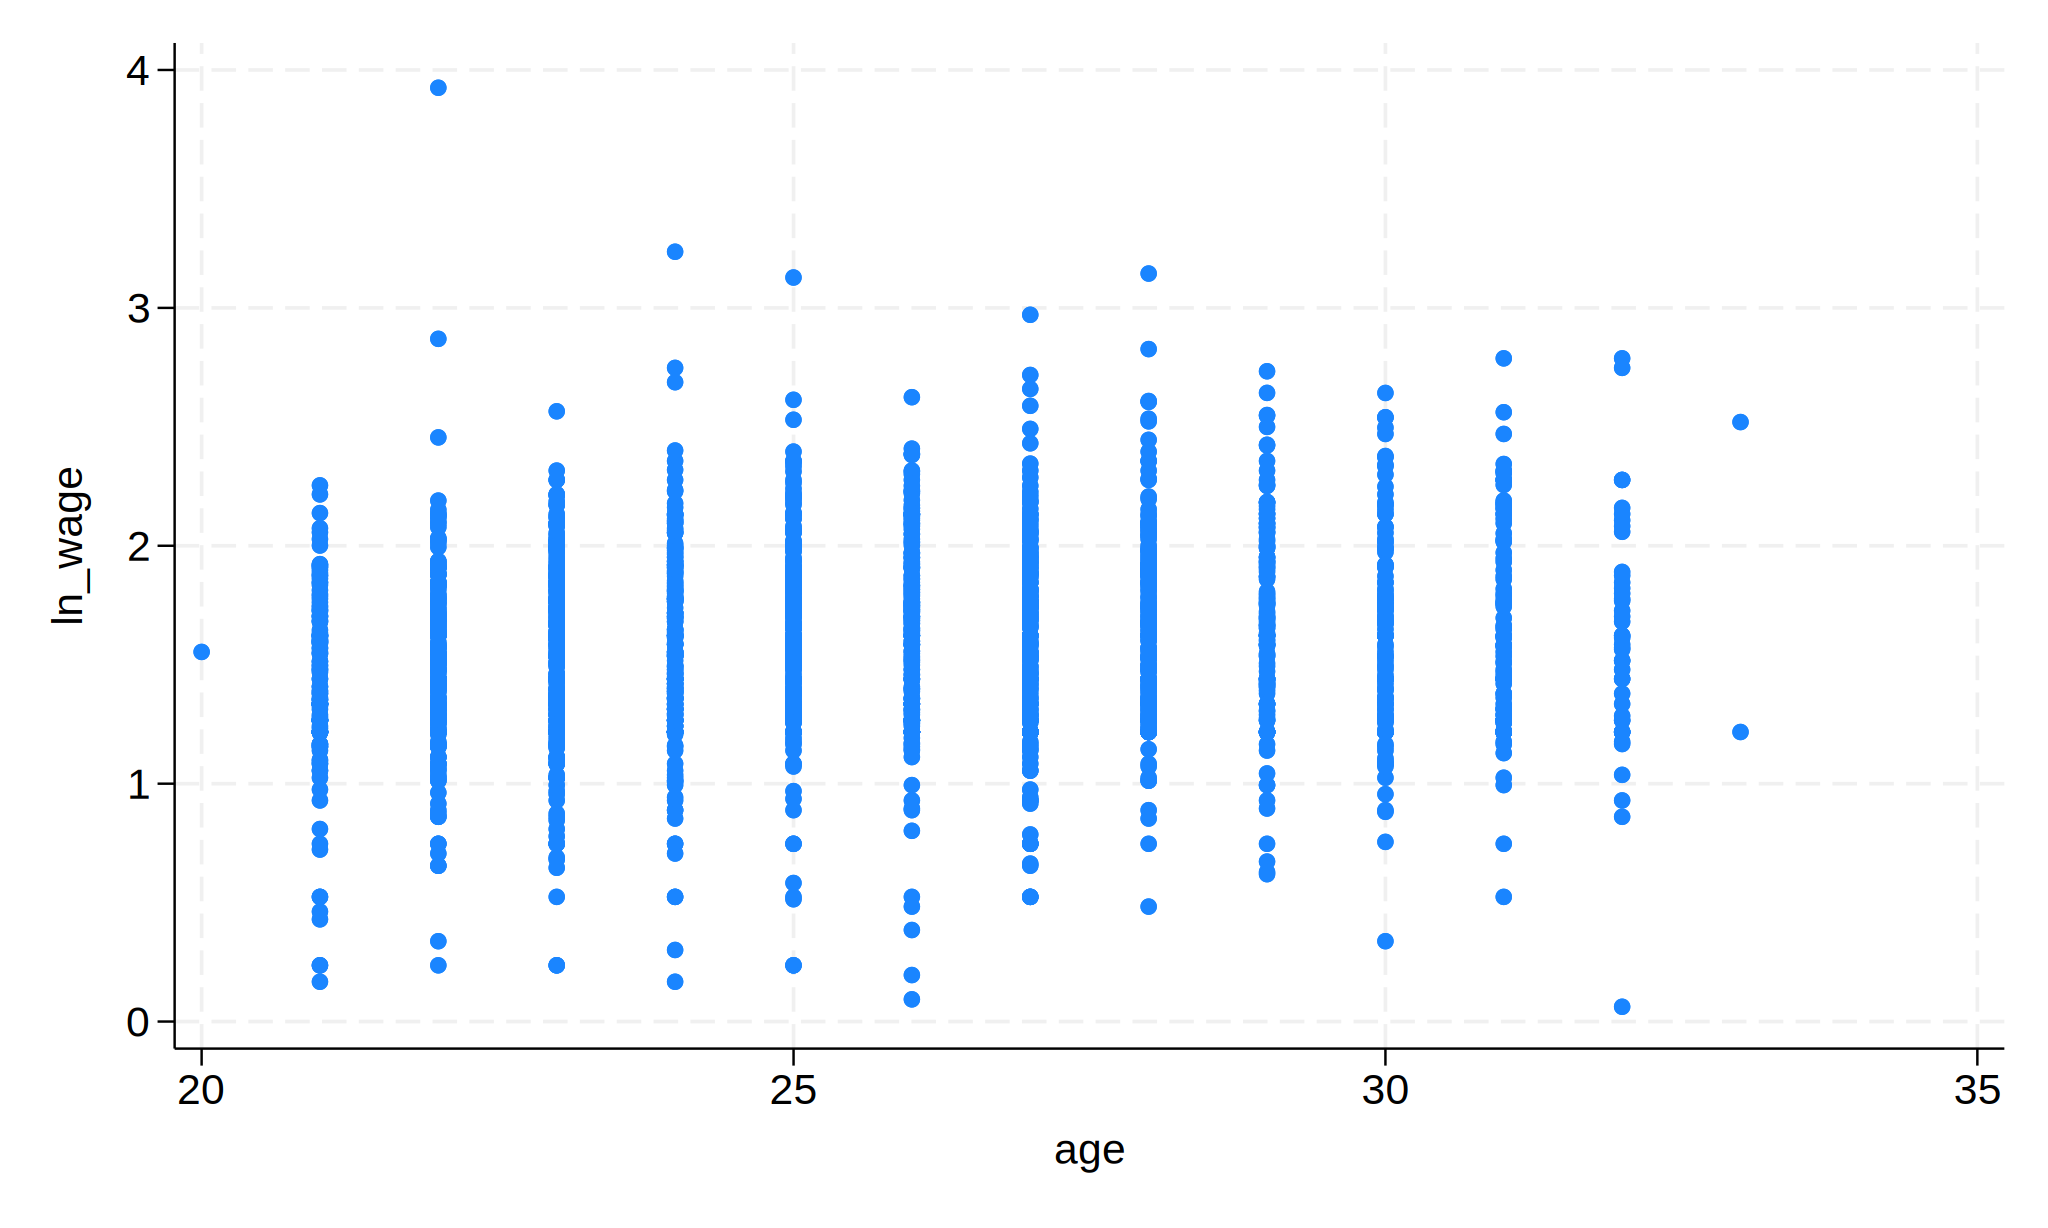

In [18]:
# stata.run('twoway scatter ln_wage age if year==75')